In [1]:
using GuSTO
using AstrobeeRobot

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/d8e061bae5267c3a13d0bb486856b0b9ddfee6ca-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/d8e061bae5267c3a13d0bb486856b0b9ddfee6ca-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...



Use "abstract type Vexity end" instead.

Use "abstract type Monotonicity end" instead.

Use "abstract type Sign end" instead.

Use "abstract type AbstractExpr end" instead.

Use "abstract type Constraint end" instead.

Use "const Value = Union{Number,AbstractArray}" instead.

Use "const ValueOrNothing = Union{Value,Void}" instead.

Use "const AbstractExprOrValue = Union{AbstractExpr,Value}" instead.

Use "const Float64OrNothing = Union{Float64,Void}" instead.

Use "const ArrayOrNothing = Union{AbstractArray,Void}" instead.


In [17]:
robot = Astrobee3D()
model = AstrobeeSE3Manifold()
env = ISSCorner();
add_obstacles1!(env)

x_init = [11.2; -0.8; 5.6]
x_goal = [10.2; 6.9; 4.2]

x_init = [x_init; zeros(3); sqrt(1/3)*[1.; 0.; 1.; 1.]; zeros(3)]
x_goal = [x_goal; zeros(3); [-0.5; 0.5; -0.5; 0.5]; zeros(3)]
# q_goal = [0.01; 0.01; 0.01; 1.]
# q_goal = -q_goal/norm(q_goal)/
# x_init = [x_init; zeros(3); [0.; 0.; 0.; 1.]; zeros(3)]
# x_goal = [x_goal; zeros(3); [0.; 0.; 0.; 1.]; zeros(3)]

N = 100
tf_guess = 70.

PD = ProblemDefinition(robot, model, env, x_init, x_goal);
TOPgusto = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
TOSgusto = TrajectoryOptimizationSolution(TOPgusto)
solve_SCP!(TOSgusto, TOPgusto, solve_gusto_cvx!, init_traj_straightline, "Gurobi", OutputFlag=0)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Tuple{Int64,Int64}) at ./deprecated.jl:57
 [3] fix! at /home/bylard/.julia/v0.6/Convex/src/variable.jl:127 [inlined]
 [4] SCPVariables{Convex.Variable,Convex.Variable}(::SCPProblem{Astrobee3D{Float64},AstrobeeSE3Manifold,ISSCorner{Float64}}) at /home/bylard/.julia/v0.6/GuSTO/src/types.jl:97
 [5] #solve_gusto_cvx!#8(::Array{Any,1}, ::Function, ::SCPSolution, ::SCPProblem{Astrobee3D{Float64},AstrobeeSE3Manifold,ISSCorner{Float64}}, ::String, ::Int64, ::Bool) at /home/bylard/.julia/v0.6/GuSTO/src/scp/scp_gusto.jl:59
 [6] (::#kw##solve_gusto_cvx!)(::Array{Any,1}, ::#solve_gusto_cvx!, ::SCPSolution, ::SCPProblem{Astrobee3D{Float64},AstrobeeSE3Manifold,ISSCorner{Float64}}, ::String, ::Int64, ::Bool) at ./<missing>:0
 [7] #solve_SCP!#7(::Array{Any,1}, ::Function, ::TrajectoryOptimizationSolution, ::TrajectoryOptimizationProblem{Astrobee3D{Float64},AstrobeeSE3Manifold,ISSCorner{Float64}}, ::#solve_

Academic license - for non-commercial use only


            (Perhaps the number of variables or constraints in the problem have changed since you last solved it?)
            Warmstart may be ineffective.
            (Perhaps the number of variables or constraints in the problem have changed since you last solved it?)
            Warmstart may be ineffective.
            (Perhaps the number of variables or constraints in the problem have changed since you last solved it?)
            Warmstart may be ineffective.
            (Perhaps the number of variables or constraints in the problem have changed since you last solved it?)
            Warmstart may be ineffective.
            (Perhaps the number of variables or constraints in the problem have changed since you last solved it?)
            Warmstart may be ineffective.


In [14]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.prob_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.omega_vec
@show TOSgusto.SCPS.param.alg.Delta_vec
;

TOSgusto.SCPS.converged = true
TOSgusto.SCPS.iterations = 4
TOSgusto.SCPS.total_time = 2.5926386889999997
TOSgusto.SCPS.accept_solution = Bool[true, true, true, true, true]
TOSgusto.SCPS.prob_status = Symbol[:NA, :Optimal, :Optimal, :Optimal, :Optimal]
TOSgusto.SCPS.convergence_measure = [0.0, 0.0521284, 0.0317051, 0.0141271, 0.000968918]
TOSgusto.SCPS.param.alg.omega_vec = [1.0, 1.0, 1.0, 1.0, 1.0]
TOSgusto.SCPS.param.alg.Delta_vec = [10.0, 10.0, 10.0, 10.0, 10.0]


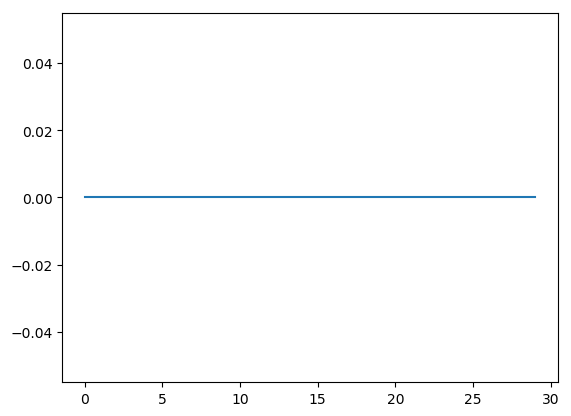

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdf18e29908>

In [4]:
plot(TOSgusto.SCPS.traj.X[13,:])

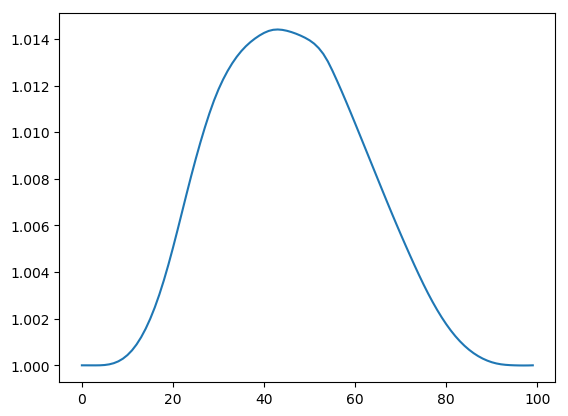

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdf1057a128>

In [18]:
# Quaternion norm
normq = [norm(TOSgusto.SCPS.traj.X[7:10,i]) for i in 1:TOSgusto.SCPS.SCPP.N]
plot(normq)

In [6]:
# Animate Astrobee trajectory
vis = Visualizer()
delete!(vis)

vis[:goal]
for (idx,obs) in enumerate(env.keepout_zones)
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3f0(x_goal[1:3]), 0.1f0),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))
end

vis[:workspace]
for (idx,ws) in enumerate(env.keepin_zones)
    if idx in (5,8)
        setobject!(vis[:workspace][Symbol(string("ws",idx))],
            Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3), depthWrite=false)))
    else
        setobject!(vis[:workspace][Symbol(string("ws",idx))],
            Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3))))
    end
end

vis[:obstacle]
for (idx,ws) in enumerate(env.obstacle_set)
    setobject!(vis[:workspace][Symbol(string("ws",idx+length(env.keepin_zones)))],
        Object(ws,MeshBasicMaterial(color=RGBA(0.95,0.26,0.26,0.3))))
end

ab = Astrobee()
mvis = MechanismVisualizer(
    ab.mechanism,
    URDFVisuals(AstrobeeRobot.urdfpath(), package_path=[dirname(dirname(AstrobeeRobot.urdfpath()))]),
    vis);

speed_factor = 1

Qs = Vector{Vector{Float64}}(0)
for k in 1:speed_factor:N
    q = [quat_inv(TOSgusto.SCPS.traj.X[7:10,k]); TOSgusto.SCPS.traj.X[1:3,k]]
    push!(Qs,q)
end

trans = Translation(14., -1., 7.)
rot = LinearMap(RotZ(-0.6)) ∘ LinearMap(RotY(-0.2))
settransform!(vis["/Cameras/default"], trans ∘ rot)
setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 1.9)
setprop!(vis["/Cameras/default/rotated/<object>"], "near", 0.05)

sleep(3)
setanimation!(mvis,1:length(Qs),Qs)

plot_in_cell = false
plot_in_cell ? IJuliaCell(vis) : open(vis)

instantiated a floating joint
Listening on 0.0.0.0:8701...


Info: Serving MeshCat visualizer at http://127.0.0.1:8701
/usr/bin/google-chrome-stable: /home/bylard/.julia/v0.6/Conda/deps/usr/lib/libuuid.so.1: no version information available (required by /usr/bin/google-chrome-stable)
/opt/google/chrome/chrome: /home/bylard/.julia/v0.6/Conda/deps/usr/lib/libuuid.so.1: no version information available (required by /opt/google/chrome/chrome)
